In [1]:
import utils
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar

In [2]:
df = pd.read_csv('/Users/allen/Documents/data_512/Data/call_data_filtered.csv')

# make YearMonth datetime type
df['Original Time Queued'] = pd.to_datetime(df['Original Time Queued'])

# filter priority 9 for this project
df = df[df['Priority'] != 9]

# filter precinct that is UNKNOWN
df = df[df['Precinct'] != 'UNKNOWN']

# Features

In [3]:
# copy original data
ds = df.copy()

In [4]:
# feature engineering
ds['Call_Hour'] = ds['Original Time Queued'].dt.hour
ds['Call_Weekday'] = ds['Original Time Queued'].dt.weekday
ds['Call_Hour_Bin'] = ds['Call_Hour'].apply(utils.create_hour_bin)

# extract holiday info
cal = calendar()
holidays = cal.holidays(start=ds['Original Time Queued'].min(), end=ds['Original Time Queued'].max())
ds['is_Holiday'] = ds['Original Time Queued'].dt.date.isin(pd.Series(holidays).dt.date).astype(int)

# encoding
ds = ds[['Call Type','Priority','Precinct','Sector','response_time','Call_Weekday','Call_Hour_Bin','is_Holiday']]
ds = pd.get_dummies(ds, 
               columns=['Call Type','Priority','Precinct','Sector','Call_Weekday','Call_Hour_Bin'],
               prefix=['Call_Type','Priority','Precinct','Sector','Call_Weekday','Call_Hour_Bin'])

# Train and Validation

In [5]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(ds.drop(columns=['response_time']),
                                                  ds['response_time'],
                                                  test_size=0.2, 
                                                  random_state=10)

# Xgboost

In [6]:
import xgboost as xgb

# prepare data
dtrain = xgb.DMatrix(X_train, label=y_train.to_numpy())
dval = xgb.DMatrix(X_val, label=y_val.to_numpy())

# paramaters options
param = {
    'objective': 'reg:squarederror',
    'eva_metric': 'rmse',
    'eta': 0.1,
    'subsample': 0.8,
    'colsample': 0.8,
    'max_depth': 6
}

# set number of trees to grow
num_round = 200

# specify validations set to watch performance
watchlist = [(dtrain, 'train'), (dval, 'eval')]

In [7]:
# train gradient boosting modol
bst = xgb.train(param, 
                dtrain, 
                num_round,
                watchlist,
                early_stopping_rounds=10,
                verbose_eval=10)

[0]	train-rmse:20.1529	eval-rmse:20.1737
Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.

Will train until eval-rmse hasn't improved in 10 rounds.
[10]	train-rmse:14.2363	eval-rmse:14.2536
[20]	train-rmse:13.3231	eval-rmse:13.3371
[30]	train-rmse:13.1977	eval-rmse:13.2113
[40]	train-rmse:13.1731	eval-rmse:13.1877
[50]	train-rmse:13.1645	eval-rmse:13.1807
[60]	train-rmse:13.1597	eval-rmse:13.1774
[70]	train-rmse:13.1563	eval-rmse:13.1752
[80]	train-rmse:13.1538	eval-rmse:13.174
[90]	train-rmse:13.1516	eval-rmse:13.1732
[100]	train-rmse:13.1498	eval-rmse:13.1728
[110]	train-rmse:13.1482	eval-rmse:13.1722
[120]	train-rmse:13.1465	eval-rmse:13.1719
[130]	train-rmse:13.1449	eval-rmse:13.1715
[140]	train-rmse:13.1437	eval-rmse:13.1712
[150]	train-rmse:13.1426	eval-rmse:13.1709
[160]	train-rmse:13.1415	eval-rmse:13.1711
Stopping. Best iteration:
[154]	train-rmse:13.142	eval-rmse:13.1709



In [8]:
# extract feature importance
imp = pd.DataFrame.from_dict(bst.get_score(importance_type='gain'), orient='index', columns=['feature']) \
    .sort_values('feature', ascending=False)

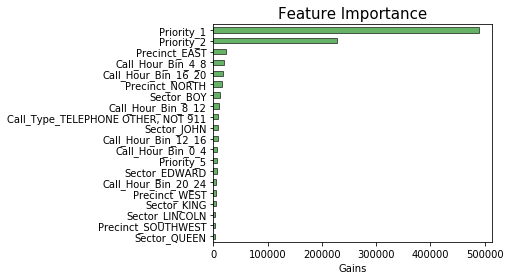

In [9]:
# plot top 20 feature importance
fig, ax = plt.subplots(figsize=(5,4))
imp.head(20).sort_values('feature') \
    .plot.barh(edgecolor='black', alpha=0.6, color='green', legend=False, ax=ax)
ax.set_title('Feature Importance', fontsize=15)
ax.set_xlabel('Gains');

In [11]:
# save model
bst.save_model('bst.model')

In [12]:
# calculate root mean square error
pred = bst.predict(dval)
math.sqrt(((y_val - pred)**2).mean())

13.17170342521235

In [ ]:
# code to load model
# bst = xgb.Booster()  # init model
# bst.load_model('bst.model')